#  QUDOS: Quantum Occupation Dynamics Simulation - Multi-Pulse and Multi-Level System

# QUDOS: Quantum Occupation Dynamics Simulation

This repository contains simulation codes for the occupation dynamics of a **4-level quantum system**.  
The software is designed to assist researchers and students in the field of **quantum optics** in gaining a better understanding of the behavior of 4-level quantum systems and various excitation schemes.

In simple terms, the software can simulate:

- Resonant Excitation  
- Two-Photon Excitation  
- The SUPER Scheme  
- Stimulated Two-Photon Excitation  
- Chirp laser pulses for Adiabatic Rapid Passage (ARP)

---

## Authors

This software was developed by:  
- **Yusuf Karli** - Main Developper -  (University of Cambridge, University of Innsbruck)  
- **Emre Sahin** - Contributor -  (The Hartree Centre STFC)  
- **Thomas K. Bracht** - Contributor - (TU Dortmund)  
- **Doris E. Reiter** - Contributor - (TU Dortmund)  

---

## Acknowledgements

We would like to express our gratitude to **Florian Kappe**, **Vikas Remesh**, and **Gregor Weihs** for their invaluable support and contributions to this project.

Special thanks to the **QuTiP project** for providing the useful functions upon which our software is built.

---

## Contributing

We welcome contributions to this project!  
If you would like to contribute:

1. Fork the repository  
2. Create a new branch for your feature or bug fix  
3. Commit your changes  
4. Submit a pull request  

---

## License

This project is licensed under the **Creative Commons Attribution 4.0 International License**.  
Visit [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

To give proper attribution, please cite the original work as follows:  
Karli, Y., Bracht, T., Sahin, M. E., Weihs, G., & Reiter, D. (2025). QUDOS: Quantum Occupation Dynamics Simulation - Multi-Pulse and Multi-Level System. Zenodo. https://doi.org/10.5281/zenodo.15009009

---

## Contact

For any questions or concerns, please feel free to contact the project maintainer:  
📧 **ysfkarli@gmail.com**


### Libraries

Pulse Generation

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Define a class named Pulse to create laser pulses 
class Pulse:
    def __init__(self, tau, e_start, w_gain=0, t0=0, e0=1, phase=0, polar_x=1):
        self.tau = tau  # in ps (tau is a time constant)
        self.e_start = e_start  # in meV (e_start is the starting energy)
        self.w_start = e_start / HBAR  # in 1 / ps (calculate angular frequency)
        self.w_gain = float(w_gain)  # in 1/ps^2 (rate of change of angular frequency)
        self.t0 = t0  # initial time
        self.e0 = e0  # initial energy
        self.phase = phase  # phase of the pulse
        self.freq = None  # frequency , initialized to None
        self.phase_ = None  # phase_ , initialized to None
        self.polar_x = polar_x  # x-component of polarization
        self.polar_y = np.sqrt(1 - polar_x ** 2)  # calculate y-component of polarization

    def __repr__(self):
        
        return "%s(tau=%r, e_start=%r, w_gain=%r, t0=%r, e0=%r)" % (
            self.__class__.__name__, self.tau, self.e_start, self.w_gain, self.t0, self.e0
        )

    def get_envelope(self, t):
        # Calculate the envelope of the pulse at a given time t
        return self.e0 * np.exp(-0.5 * ((t - self.t0) / self.tau) ** 2) / (np.sqrt(2 * np.pi) * self.tau)
    
    def set_frequency(self, f):
        #Set the time-dependent frequency using a lambda function f that takes time t.
        
        self.freq = f

    def get_frequency(self, t):
        #Calculate the frequency (omega) for a given time t.
        
        if self.freq is not None:
            return self.freq(t)
        return self.w_start + self.w_gain * (t - self.t0)

    def get_full_phase(self, t):
        # Calculate the full phase of the pulse at a given time t
        return self.w_start * (t - self.t0) + 0.5 * self.w_gain * ((t - self.t0) ** 2) + self.phase
    
    def get_energies(self):
        #Get the energy difference of +- tau for a chirped pulse.
        
        low = self.get_frequency(-self.tau)
        high = self.get_frequency(self.tau)
        energy_range = np.abs(high - low) * HBAR  # Calculate energy range in meV
        return energy_range

    def get_total(self, t):
        # Calculate pulse envelope at a given time t
        return self.get_envelope(t) * np.exp(-1j * self.get_full_phase(t))


# Chirping the laser pulses
class ChirpedPulse(Pulse):
    def __init__(self, tau_0, e_start, alpha=0, t0=0, e0=1 * np.pi, polar_x=1):
        self.tau_0 = tau_0  # Initial tau value
        self.alpha = alpha  # Chirp Value
        # Initialize the ChirpedPulse using parameters and super() to call the parent class's constructor
        super().__init__(tau=np.sqrt(alpha**2 / tau_0**2 + tau_0**2), e_start=e_start, w_gain=alpha / (alpha**2 + tau_0**4), t0=t0, e0=e0, polar_x=polar_x)
    
    def get_parameters(self):
        """
        Returns tau and chirp parameter.
        """
        return "tau: {:.4f} ps , a: {:.4f} ps^-2".format(self.tau, self.w_gain)

    def get_envelope(self, t):
        # Calculate the pulse envelope  at a given time t
        return self.e0 * np.exp(-0.5 * ((t - self.t0) / self.tau) ** 2) / (np.sqrt(2 * np.pi * self.tau * self.tau_0))

    def get_ratio(self):
        """
        Returns the ratio of pulse area chirped/unchirped: tau / sqrt(tau * tau_0).
        """
        return np.sqrt(self.tau / self.tau_0)



**4-Level system functions**  
The following function defines the time evolution of 4-Level system (exciton and biexciton).  

If you don't want to have cavity you can just use biexciton function.

In [2]:
# Biexciton Function - Run this function
HBAR = 0.6582173  # meV*ps

def energies(delta_b=4., delta_0=0.):
    # energy levels of the system
    E_X = -delta_0/2
    E_Y =  delta_0/2
    E_B = -delta_b
    return E_X, E_Y, E_B

def biexciton_system(collapse= "nodecay", tau1=1, tau2=1, area1=1*np.pi, area2=0, det1=0, det2=0, alpha1=0, alpha2=0, prob_b=1/2,
    pol1_x=1, pol2_x=1, delay=1, delta_b=4, delta_0=0.0, gamma_e=1/100, gamma_b=1/100, epsilon=0.01, 
    dt_1=0.1, dt_2=0.1, options=qt.Options(atol=1e-7), mode="population", g2_pol="x"
    ):
    """
    In qutip, every energy has to be provided in 1/ps
    Here, a rotating frame with the unsplit exciton energy is chosen. 
    collapse: choose "spontane" if you wanna include decay otherwise choose "coherent" to leave collapse operators empty. 
    tau1/2: pulse 1/2 duration in ps
    area1/2: pulsearea of pulse 1/2
    det1/2: detuning of pulse 1/2 to unsplit exciton energy in meV
    alpha1/2: chirp of pulse1/2 in ps^2
    pol1/2_x: x polarization component of pulse 1/2. possible options = 0,...,1
    delay: delay of pulse 2 to pulse 1 in ps
    delta_b: biexciton binding in meV
    delta_0: exciton X/Y splitting in meV (FSS)
    gamma_e: inverse exciton lifetime in 1/ps
    gamma_b: inverse biexciton lifetime in 1/ps
    epsilon: exponential decay, until epsilon is reached
    dt_1: timestep during pulse (0,..,8tau)
    dt_2: timestep after the pulse, during the decay
    mode: "pop" for population. This is for various possible modes in the future. 
    """
    delta_b = delta_b / HBAR  # delta_b in 1/ps
    delta_0 = delta_0 / HBAR

    # system states
    g =qt.basis(4,0)
    x = qt.basis(4,1)
    y = qt.basis(4,2)
    b = qt.basis(4,3)
    
    # Initialize the ground state. For example, if you want to start from the ground state, set prob_b to zero.
    # "prob_b" represents the probability amplitude of the biexciton state. If you want to start with a superposition of the ground state and exciton, then change "np.sqrt(prob_b) * b" to "x" or "y".
    # If you want to have a superposition of the ground state, exciton, and biexciton, then you can change "gxbas" as you wish.
    
    gxbas =np.sqrt(1-prob_b)*g + np.sqrt(prob_b)*b

    # number operators
    n_g = g * g.dag()
    n_x = x * x.dag()
    n_y = y * y.dag()
    n_b = b * b.dag()

    # transition operators / polarizations
    p_gx = g * x.dag()
    p_gy = g * y.dag()
    p_xb = x * b.dag()
    p_yb = y * b.dag()
    # this one is not needed for the hamiltonian
    p_gb = g * b.dag()

    # Check the value of the collapse parameter
    if collapse == "nodecay":
        # Collapse operators (empty for a coherent process)
        c_ops = []

    # Check the value of the collapse parameter
    if collapse == "decay":
        # Define collapse operators for spontaneous emission
        c_ops = [np.sqrt(gamma_e) * p_gx, np.sqrt(gamma_e) * p_gy, np.sqrt(gamma_b) * p_xb, np.sqrt(gamma_b) * p_yb]

    # system Hamiltonian
    E_X, E_Y, E_B = energies(delta_b=delta_b, delta_0=delta_0) # note they are already divided by HBAR
    H_sys = E_X * n_x + E_Y * n_y + E_B * n_b

    # pulse 1 and 2, right now assume delay > 0
    tau11=np.sqrt(alpha1**2 / tau1**2 + tau1**2)
    tau22=np.sqrt(alpha2**2 / tau2**2 + tau2**2)
    # choose the longer of the two
    t_start1 = 4*tau11 #if tau11 > tau22 else 4*tau22
    # further delay pulse 2
    t_start2 = t_start1 + delay
    pulse1 = ChirpedPulse(tau1, det1, alpha1, t0=t_start1, e0=area1, polar_x=pol1_x)
    pulse2 = ChirpedPulse(tau2, det2, alpha2, t0=t_start2, e0=area2, polar_x=pol2_x)

    # excitation Hamiltonians (daggered, as expressed by polarization operators)
    H_x_dag = -0.5 * (p_gx + p_xb)  # this has to be paired with the conjugated total x-field 
    H_y_dag = -0.5 * (p_gy + p_yb)
    # print(H_x_dag.dag())

    H = [H_sys, [H_x_dag, lambda t,args : np.conj(pulse1.polar_x*pulse1.get_total(t) + pulse2.polar_x*pulse2.get_total(t))],
                [H_y_dag, lambda t,args : np.conj(pulse1.polar_y*pulse1.get_total(t) + pulse2.polar_y*pulse2.get_total(t))],
                [H_x_dag.dag(), lambda t,args : pulse1.polar_x*pulse1.get_total(t) + pulse2.polar_x*pulse2.get_total(t)],
                [H_y_dag.dag(), lambda t,args : pulse1.polar_y*pulse1.get_total(t) + pulse2.polar_y*pulse2.get_total(t)]]
    
    # time axes. has to start at 0 due to limitations in the function calculating the 2-time quantities
    # two different time steps are used: a small dt_1, during the time the pulses are active, and a larger dt_2 during the decay 
    # time axis during the pulses
    t_off = t_start2 + t_start1  # time window where pulse 1 or 2 is still active
    rate = 2*gamma_b if 2*gamma_b<gamma_e else gamma_e
    t_end = t_off - 1/rate *np.log(epsilon)  # note that log(epsilon) is in general negative
    t_axis1 = np.arange(0, t_off, dt_1)
    t_axis2 = np.arange(t_off, t_end, dt_2)  # note that arange does not include the final value so t_off is not in both arrays
    t_axis = np.append(t_axis1, t_axis2)

    if mode == "population":
        g_occ, x_occ, y_occ, b_occ, polar_gx, polar_xb, polar_gb = qt.mesolve(H, gxbas, t_axis, c_ops=c_ops, e_ops=[n_g, n_x, n_y, n_b, p_gx, p_xb, p_gb], options=options).expect
        return g_occ, x_occ, y_occ, b_occ, polar_gx, polar_xb, polar_gb, t_axis, #tau1, tau2, area1, area2, det1, det2, alpha1, alpha2, pol1_x, pol2_x, delay, delta_b, delta_0, gamma_e, gamma_b


c:\Users\yusuf\AppData\Local\Programs\Python\Python313\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


If you wanna have 0,1,2 photon modes simple cavity option you can use the cav_biexction_function.

In [8]:
# Cavity Biexciton Function - Run this function
HBAR = 0.6582173  # meV*ps

def energies(delta_b=4., delta_0=0.):
    # energy levels of the system
    E_X = -delta_0/2
    E_Y =  delta_0/2
    E_B = -delta_b
    return E_X, E_Y, E_B

def cav_biexciton_system(collapse= "coherent", tau1=1, tau2=1, area1=1*np.pi, area2=0, det1=0, det2=0, alpha1=0, alpha2=0, prob_b=0,
    pol1_x=1, pol2_x=1, delay=1, delta_b=4, delta_0=0.0, gamma_e=1/100, gamma_b=1/100, kappa=1/2,g_cav=0.05, epsilon=0.01, 
    dt_1=0.1, dt_2=0.1, options=qt.Options(atol=1e-7), mode="pop"
    ):
    """
    in qutip, every energy has to be provided in 1/ps
    Here, a rotating frame with the unsplit exciton energy is chosen.
    collapse: choose "decay" if you wanna include decay otherwise choose "nodecay" to leave collapse operators empty.  
    tau1/2: pulse 1/2 duration in ps
    area1/2: pulsearea of pulse 1/2
    det1/2: detuning of pulse 1/2 to unsplit exciton energy in meV
    alpha1/2: chirp of pulse1/2 in ps^2
    pol1/2_x: x polarization component of pulse 1/2. possible options = 0,...,1
    delay: delay of pulse 2 to pulse 1 in ps
    delta_b: biexciton binding in meV
    delta_0: exciton X/Y splitting in meV (FSS)
    gamma_e: inverse exciton lifetime in 1/ps
    gamma_b: inverse biexciton lifetime in 1/ps
    epsilon: exponential decay, until epsilon is reached
    dt_1: timestep during pulse (0,..,8tau)
    dt_2: timestep after the pulse, during the decay
    mode: "pop" for population or "g2" for g2
    g2_pol: "x" or "y", g2 of x or y polarized light
    kappa: cavity decay rate in 1/ps
    g_cav =  cavity coupling strength in 1/ps
    """
    delta_b = delta_b / HBAR  # delta_b in 1/ps
    delta_0 = delta_0 / HBAR
    #gamma_b = gamma_b / 2  # both X and Y decay. the input gamma_b is 1/tau_b, where tau_b is the lifetime of the biexciton

    # system states
    g =qt.basis(4,0)
    x = qt.basis(4,1)
    y = qt.basis(4,2)
    b = qt.basis(4,3)

    # Initialize the ground state. For example, if you want to start from the ground state, set prob_b to zero.
    # "prob_b" represents the probability amplitude of the biexciton state. If you want to start with a superposition of the ground state and exciton, then change "np.sqrt(prob_b) * b" to "x" or "y".
    # If you want to have a superposition of the ground state, exciton, and biexciton, then you can change "gxbas" as you wish.
    gxbas =np.sqrt(1-prob_b)*g + np.sqrt(prob_b)*b

    # Cavity states for 0, one and two photon states.
    c0 = qt.basis(3, 0) # vacuum
    c1 = qt.basis(3, 1) # 1 photon
    c2 = qt.basis(3, 2) # 2 photons
   
    psi0 = qt.tensor(gxbas, qt.tensor(c0, c0))  # total initial state
    # Update system states to include the cavity
    g = qt.tensor(g, qt.tensor(c0, c0))
    x = qt.tensor(x, qt.tensor(c0, c0))
    y = qt.tensor(y, qt.tensor(c0, c0))
    b = qt.tensor(b, qt.tensor(c0, c0))

   # photon annihilation and creation operators
    a_h = qt.tensor(qt.qeye(4), qt.tensor(qt.destroy(3), qt.identity(3)))
    a_v = qt.tensor(qt.qeye(4), qt.tensor(qt.identity(3), qt.destroy(3)))
    a_h_dag = a_h.dag()
    a_v_dag = a_v.dag()
  

    # number operators
    n_g = g * g.dag()
    n_x = x * x.dag()
    n_y = y * y.dag()
    n_b = b * b.dag()

    # transition operators / polarizations
    p_gx = g * x.dag()
    p_gy = g * y.dag()
    p_xb = x * b.dag()
    p_yb = y * b.dag()
    # this one is not needed for the hamiltonian
    p_gb = g * b.dag()

    # Check the value of the collapse parameter
    if collapse == "nodecay":
        # Collapse operators (empty for non decay process)
        c_ops = []

    # Check the value of the collapse parameter
    if collapse == "decay":
        # Define collapse operators for spontaneous emission
        c_ops = [np.sqrt(gamma_e) * p_gx, np.sqrt(gamma_e) * p_gy, np.sqrt(gamma_b) * p_xb, np.sqrt(gamma_b) * p_yb]

    # pulse 1 and 2, right now assume delay > 0
    tau11=np.sqrt(alpha1**2 / tau1**2 + tau1**2)
    tau22=np.sqrt(alpha2**2 / tau2**2 + tau2**2)
    # choose the longer of the two
    t_start1 = 4*tau11 #if tau11 > tau22 else 4*tau22
    # further delay pulse 2
    t_start2 = t_start1 + delay
    pulse1 = ChirpedPulse(tau1, det1, alpha1, t0=t_start1, e0=area1, polar_x=pol1_x)
    pulse2 = ChirpedPulse(tau2, det2, alpha2, t0=t_start2, e0=area2, polar_x=pol2_x)

    # excitation Hamiltonians (daggered, as expressed by polarization operators)
    H_x_dag = -0.5 * (p_gx + p_xb)  # this has to be paired with the conjugated total x-field 
    H_y_dag = -0.5 * (p_gy + p_yb)
    # print(H_x_dag.dag())

   # system Hamiltonian
    E_X, E_Y, E_B = energies(delta_b=delta_b, delta_0=delta_0) # note they are already divided by HBAR

    g_cav = g_cav/ HBAR  # cavity coupling strength in 1/ps
    H_0 =  0 * (a_h_dag * a_h + a_v_dag * a_v)
    H_1 = g_cav * a_h_dag * (p_gx + p_xb) ; H_2 = g_cav * a_v_dag * (p_gy + p_yb)
    H_photon = H_0 + H_1 + H_1.dag() + H_2 + H_2.dag()

    H_sys = E_X * n_x + E_Y * n_y + E_B * n_b
    H_sys = H_sys + H_photon

    H = [H_sys, [H_x_dag, lambda t,args : np.conj(pulse1.polar_x*pulse1.get_total(t) + pulse2.polar_x*pulse2.get_total(t))],
                [H_y_dag, lambda t,args : np.conj(pulse1.polar_y*pulse1.get_total(t) + pulse2.polar_y*pulse2.get_total(t))],
                [H_x_dag.dag(), lambda t,args : pulse1.polar_x*pulse1.get_total(t) + pulse2.polar_x*pulse2.get_total(t)],
                [H_y_dag.dag(), lambda t,args : pulse1.polar_y*pulse1.get_total(t) + pulse2.polar_y*pulse2.get_total(t)]]
    
    # time axes. has to start at 0 due to limitations in the function calculating the 2-time quantities
    # two different time steps are used: a small dt_1, during the time the pulses are active, and a larger dt_2 during the decay 
    # time axis during the pulses
    t_off = t_start2 + t_start1  # time window where pulse 1 or 2 is still active
    rate = 2*gamma_b if 2*gamma_b<gamma_e else gamma_e
    t_end = t_off - 1/rate *np.log(epsilon)  # note that log(epsilon) is in general negative
    t_axis1 = np.arange(0, t_off, dt_1)
    t_axis2 = np.arange(t_off, t_end, dt_2)  # note that arange does not include the final value so t_off is not in both arrays
    t_axis = np.append(t_axis1, t_axis2)
    t_axis= np.arange(0, 1000, dt_1)

    if mode == "pop":
        rho = qt.mesolve(H, psi0, t_axis, c_ops=c_ops, options=options)
        g_occ, x_occ, y_occ, b_occ, polar_gx, polar_xb, polar_gb, c_occ_y, c_occ_h = qt.mesolve(H, psi0, t_axis, c_ops=c_ops, e_ops=[n_g, n_x, n_y, n_b, p_gx, p_xb, p_gb, a_v_dag*a_v, a_h_dag*a_h ], options=options).expect
        return g_occ, x_occ, y_occ, b_occ, polar_gx, polar_xb, polar_gb, t_axis, c_occ_y, c_occ_h , rho#tau1, tau2, area1, area2, det1, det2, alpha1, alpha2, pol1_x, pol2_x, delay, delta_b, delta_0, gamma_e, gamma_b


### Example: Simple Four Level with SUPER

Simulation:

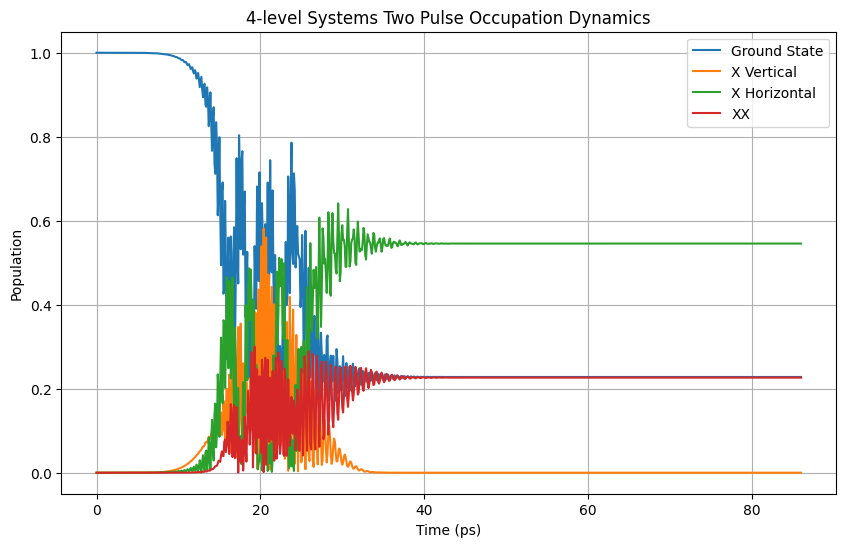

In [3]:
gamma_e=1/10 ; gamma_b=1/10 ; 
g, x,y,b,gx,xb,gb,t = biexciton_system(collapse="nodecay", tau1=5, dt_1=0.1,dt_2=0.1, prob_b=0,
            gamma_b=gamma_b, gamma_e=gamma_e, delta_b=4,
            area1=44*np.pi, alpha1=0, det1=-5, pol1_x=np.sqrt(1), pol2_x=np.sqrt(0), 
            tau2=6 ,alpha2=0, area2=35*np.pi, det2=-10.5, delay=0, mode="population"
            ) 

plt.figure(figsize=(10, 6))
plt.plot(t, g, label="Ground State")
plt.plot(t, x, label="X Vertical")
plt.plot(t, y, label="X Horizontal")
plt.plot(t, b, label="XX")
plt.xlabel("Time (ps)")
plt.ylabel("Population")
plt.title("4-level Systems Two Pulse Occupation Dynamics")
plt.legend()
plt.grid(True)
plt.show()

### Example 2 : A few level Rabi Oscillations  - No decay

This example can be used to demonstrate **s-shell (RF)** or **TPE** Rabi oscillations without *phonons*.  

There are two pulses that can be defined.  
- You can specify pulse durations, pulse areas, detunings, chirp values, or polarization for both pulses.
- You can also define the time delay between pulses.

For example, if I want to simulate s-shell resonant excitation with a single pulse, I can simply set area2 to zero, so I will  have only one pulse that I can define.  
If I set the detuning of the first pulse(det1) to 0, this means my first pulse will be resonant with the exciton energy, and I can quickly scan the pulse area to observe how the exciton population changes with respect to the pulse area.  
Then, we would observe that for a pi pulse area, we get maximum occupation, and this repeats with 3pi and 5pi as expected.

Simulation

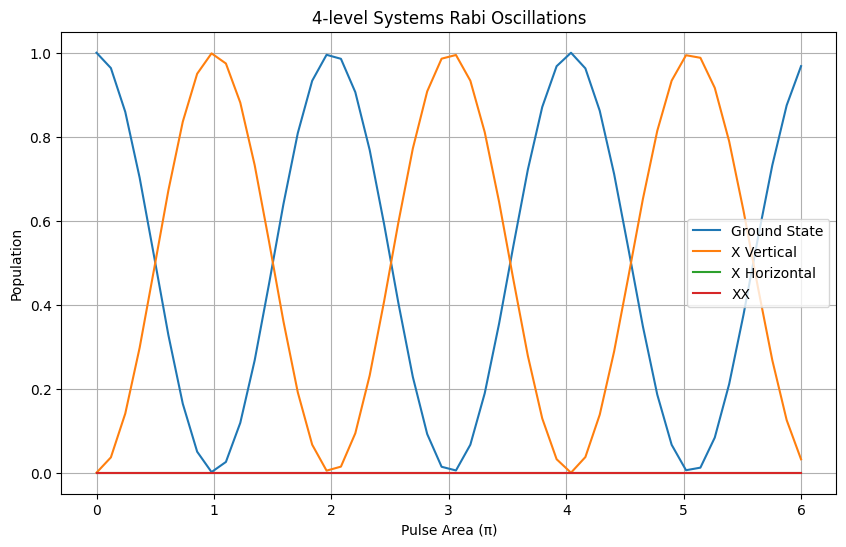

In [4]:
# Define ranges for area1 and det1 parameters
area1_values = np.linspace(0, 6, 50)  # Adjust the range and number of points as needed
det1= 0

# Initialize 2D array to store maximum b values and 3D arrays for g, x, y, and b
b_pop = np.zeros(len(area1_values))
g_pop, x_pop, y_pop = np.zeros(len(area1_values)), np.zeros(len(area1_values)), np.zeros(len(area1_values))

g_values, x_values, y_values, b_values = ([] for i in range(4)) 

# Iterate through area1 and det1 values
for i, area1 in enumerate(area1_values):
        gamma_e=1; gamma_b=1 ; 
        g, x,y,b,gx,xb,gb,t = biexciton_system(collapse="nodecay", tau1=2, dt_1=0.1,dt_2=0.01, prob_b=0,
                    gamma_b=gamma_b, gamma_e=gamma_e, delta_b=4,
                    area1=area1*np.pi, alpha1=0, det1=det1, pol1_x=1, pol2_x=np.sqrt(1), 
                    tau2=3 ,alpha2=0, area2=0*np.pi, det2=-4, delay=10, mode="population"
                    ) 
        
        b_pop[i] = b[-1]  # Store the maximum b value for this combination of area1 and det1
        g_pop[i], x_pop[i], y_pop[i] = g[-1], x[-1], y[-1]

        g_values, x_values, y_values, b_values = g, x, y, b  # Store the function outputs

plt.figure(figsize=(10, 6))
plt.plot(area1_values, g_pop, label="Ground State")
plt.plot(area1_values, x_pop, label="X Vertical")
plt.plot(area1_values, y_pop, label="X Horizontal")
plt.plot(area1_values, b_pop, label="XX")
plt.xlabel("Pulse Area (π)")
plt.ylabel("Population")
plt.title("4-level Systems Rabi Oscillations")
plt.legend()
plt.grid(True)
plt.show()

As you can see in the figure above, there is no biexciton occupation because the 1st laser pulse is not resonant with the Two-Photon Resonant energy, which, in this example, would be -2 meV, as the binding energy of the biexciton is defined as 4 meV.

**What about TPE**  

we still need single pulse but this pulse needs to be resonant to the TPE level. If you set det1 to the -2 mev (please rememebr this value is half of the defined biexciton binding energy) then we should see XX occupation.  
Also remember from your quantum optics lectures that TPE requires more pulse area compare to RF so give more juice to the laser pulses.  

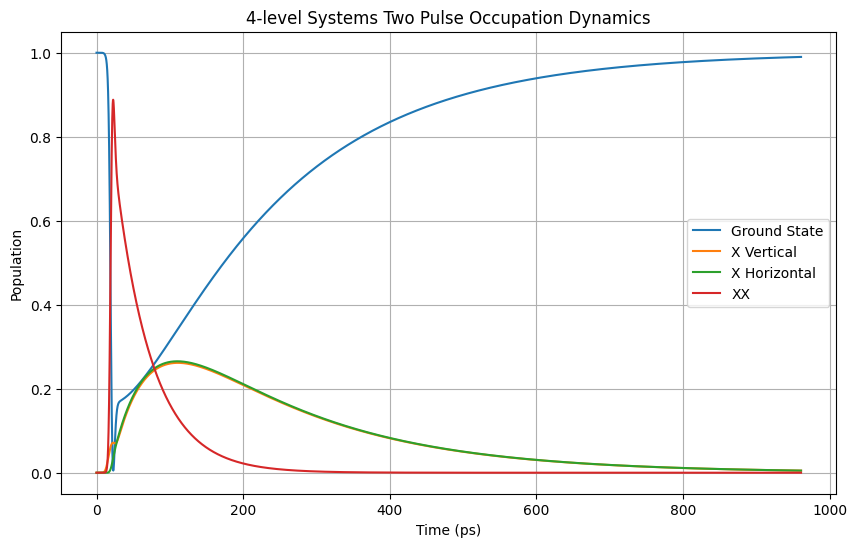

In [20]:
gamma_e=1/200 ; gamma_b=1/100 ; 
g, x,y,b,gx,xb,gb,t = biexciton_system(collapse="decay", tau1=5, dt_1=0.1,dt_2=0.1, prob_b=0,
            gamma_b=gamma_b, gamma_e=gamma_e, delta_b=4,
            area1=7*np.pi, alpha1=0, det1=-2, pol1_x=np.sqrt(1), pol2_x=np.sqrt(0), 
            tau2=6 ,alpha2=0, area2=0*np.pi, det2=-4, delay=0, mode="population"
            ) 

plt.figure(figsize=(10, 6))
plt.plot(t, g, label="Ground State")
plt.plot(t, x, label="X Vertical")
plt.plot(t, y, label="X Horizontal")
plt.plot(t, b, label="XX")
plt.xlabel("Time (ps)")
plt.ylabel("Population")
plt.title("4-level Systems Two Pulse Occupation Dynamics")
plt.legend()
plt.grid(True)
plt.show()

As you can see in the figure above, this time we have occupied the biexciton instead of the exciton.  
Please note that there is no spontaneous decay process here, which is why we don't observe any cascaded emission of excitons after the biexciton decay. We can easily change this by modifying our simulation to include decay with added lifetimes for the states.

### Example 3 : Stimulated Two Photon Excitaiton

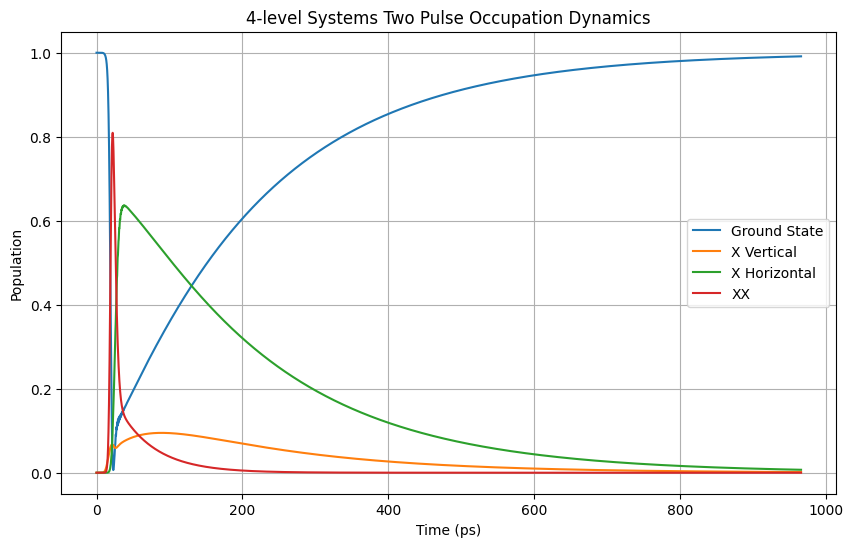

In [21]:
gamma_e=1/200 ; gamma_b=1/100 ; 
g, x,y,b,gx,xb,gb,t = biexciton_system(collapse="decay", tau1=5, dt_1=0.1,dt_2=0.1, prob_b=0,
            gamma_b=gamma_b, gamma_e=gamma_e, delta_b=4,
            area1=7*np.pi, alpha1=0, det1=-2, pol1_x=np.sqrt(1), pol2_x=np.sqrt(0), 
            tau2=6 ,alpha2=0, area2=1*np.pi, det2=-4, delay=5, mode="population"
            ) 

plt.figure(figsize=(10, 6))
plt.plot(t, g, label="Ground State")
plt.plot(t, x, label="X Vertical")
plt.plot(t, y, label="X Horizontal")
plt.plot(t, b, label="XX")
plt.xlabel("Time (ps)")
plt.ylabel("Population")
plt.title("4-level Systems Two Pulse Occupation Dynamics")
plt.legend()
plt.grid(True)
plt.show()

### Example 4: With Cavity

In [ ]:
def figOccup():
    fig = go.Figure()
    #fig = px.line(x=t, y=x)
    fig.add_scatter(x=t, y=g,name="Ground State" )
    fig.add_scatter(x=t, y=x,name="X" )
    fig.add_scatter(x=t, y=y,name="Y" )
    fig.add_scatter(x=t, y=b,name="B")
    #fig.add_scatter(x=t, y=np.imag(gx)+0.5,name="IMAG G to X")    
    #fig.add_scatter(x=t, y=np.real(gx),name="REAL G to X")    
    fig.add_scatter(x=t, y=np.abs(gx),name="ABS G to X")    
    fig.add_scatter(x=t, y=abs(xb),name="X to B")
    fig.add_scatter(x=t, y=abs(gb),name="G to B")
    fig.add_scatter(x=t, y=c_occ_y,name="Cavity Y")
    fig.add_scatter(x=t, y=c_occ_h,name="Cavity X")


    fig.update_layout(
            autosize=False,
        width=800,
        height=500,
        title=f"4-level Systems Two Pulse Occupation Dynamics <br> Max XX= {np.max(b):.2f}",
        xaxis_title="Time(ps)",
        yaxis_title="Population",
        legend_title="Level",
        font=dict(
            family="Courier New, monospace",
            size=18,
            #color="RebeccaPurple"
        ), template="plotly_dark"
    )
    #fig.update_xaxes(range=[0, 100])
    fig.show()  

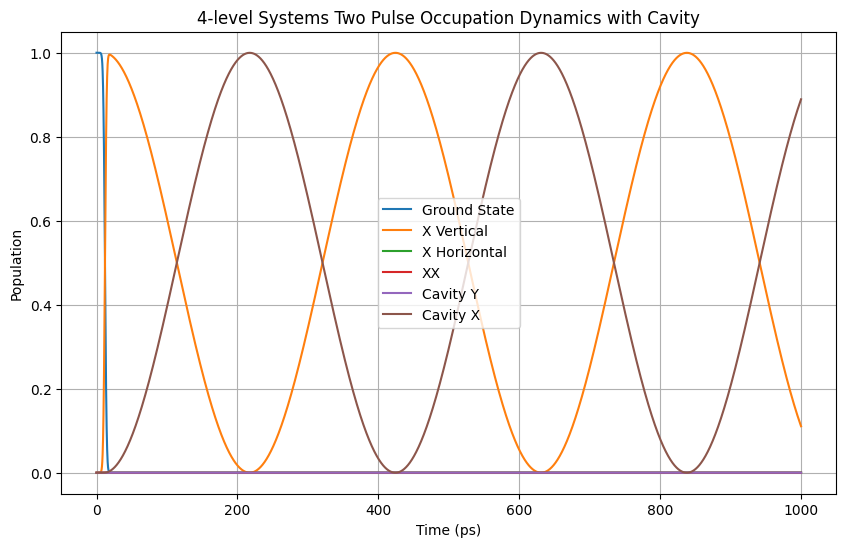

In [22]:
gamma_e=1/10 ; gamma_b=1/10
g, x, y, b, gx, xb, gb, t, c_occ_y, c_occ_h, rho = cav_biexciton_system(collapse="nodecay", tau1=3, dt_1=0.1, dt_2=0.1, prob_b=0, kappa=200, g_cav=0.005,
    gamma_b=gamma_b, gamma_e=gamma_e, delta_b=4,
    area1=1*np.pi, alpha1=0, det1=0, pol1_x=1, pol2_x=np.sqrt(1), 
    tau2=3, alpha2=0, area2=0*np.pi, det2=-10.5, delay=10, mode="pop")


plt.figure(figsize=(10, 6))
plt.plot(t, g, label="Ground State")
plt.plot(t, x, label="X Vertical")
plt.plot(t, y, label="X Horizontal")
plt.plot(t, b, label="XX")
plt.plot(t, c_occ_y, label="Cavity Y")
plt.plot(t, c_occ_h, label="Cavity X")
plt.xlabel("Time (ps)")
plt.ylabel("Population")
plt.title("4-level Systems Two Pulse Occupation Dynamics with Cavity")
plt.legend()
plt.grid(True)
plt.show()